# Use PyTorch to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning service. It introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.9.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Create model definition](#model_def)
3.	[Train model](#training)
4.  [Persist trained model](#persist)
5.	[Deploy and Score](#deploy)
6.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [ ]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [76]:
wml_credentials = {
    "username": username,
    "apikey": api_key,
    "url": url,
    "instance_id": 'openshift',
    "version": '4.5'
}

Alternatively you can use `username` and `password` to authenticate WML services.

```
wml_credentials = {
    "username": ***,
    "password": ***,
    "url": ***,
    "instance_id": 'openshift',
    "version": '4.5'
}

```

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="https://ibm.github.io/watson-machine-learning-sdk//" target="_blank" rel="noopener no referrer">here</a>.

In [ ]:
!pip install -U ibm-watson-machine-learning

In [3]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use `{PLATFORM_URL}/ml-runtime/spaces?context=icp4data` to create one.

- Click New Deployment Space
- Create an empty space
- Go to space `Settings` tab
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd4.5/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [3]:
space_id = 'PASTE YOUR SPACE ID HERE'

You can use `list` method to print all existing spaces.

In [ ]:
client.spaces.list(limit=10)

To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [4]:
client.set.default_space(space_id)

'SUCCESS'

<a id="model_def"></a>
# 2. Create model definition

### 2.1 Prepare model definition metadata

In [5]:
model_definition_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "PyTorch Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "PyTorch Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.COMMAND:  "torch_mnist.py --epochs 1",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.8"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

### 2.2  Get sample model definition content file from git

In [6]:
import wget, os

filename='pytorch-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.5/definitions/pytorch/mnist/pytorch-model.zip')

**Tip**: Convert below cell to code and run it to see model deinition's code.

### 2.3  Publish model definition

In [39]:
definition_details = client.model_definitions.store(filename, model_definition_metadata)

In [40]:
model_definition_id = client.model_definitions.get_id(definition_details)
print(model_definition_id)

865900f5-c2eb-4d0b-96dd-c2d310771318


#### List models definitions

In [ ]:
client.model_definitions.list(limit=5)

<a id="training"></a>
# 3. Train model

#### **Warning**: Before executing deep learning experiment make sure that [training data](https://github.com/IBM/watson-machine-learning-samples/tree/master/cpd4.5/data/mnist/raw) is saved in a folder where Watson Machine Learning Accelerator is installed.

### 3.1 Prepare training metadata

In [41]:
training_metadata = training_metadata = {
   client.training.ConfigurationMetaNames.NAME: "PyTorch hand-written Digit Recognition",
   client.training.ConfigurationMetaNames.DESCRIPTION: "PyTorch hand-written Digit Recognition",
   client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
      "name":"MNIST results",
      "connection":{
         
      },
      "location":{
         "path":f"spaces/{space_id}/assets/experiment"
      },
      "type":"fs"
   },
  client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_id,
        "hardware_spec": {
          "name": "K80",
          "nodes": 1
        },
        "software_spec": {
          "name": "pytorch-onnx_rt22.1-py3.9"
        }
  },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
      {
         "name":"training_input_data",
         "type":"fs",
         "connection":{
            
         },
         "location":{
            "path": "pytorch-mnist"
         },
         "schema":{
            "id":"idmlp_schema",
            "fields":[
               {
                  "name":"text",
                  "type":"string"
               }
            ]
         }
      }
   ]
}

### 3.2 Train the model in the background

In [42]:
training = client.training.run(training_metadata)

### 3.3 Get training id and status

In [43]:
training_id = client.training.get_id(training)
print(training_id)

46a8b4c9-6797-4825-8a46-112018e69c34


In [45]:
client.training.get_status(training_id)['state']

'completed'

### 3.4 Get training details

In [ ]:
import json

training_details = client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

#### List trainings

In [ ]:
client.training.list(limit=5)

#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to  delete train runs and results add `hard_delete=True` as a parameter.

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Publish model

In [47]:
software_spec_uid = client.software_specifications.get_uid_by_name('pytorch-onnx_rt22.1-py3.9')

In [48]:
model_meta_props = {client.repository.ModelMetaNames.NAME: "PyTorch Mnist Model",
                    client.repository.ModelMetaNames.TYPE: "pytorch-onnx_1.10",
                    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }

published_model_details = client.repository.store_model(training_id, meta_props=model_meta_props)
model_uid = client.repository.get_model_id(published_model_details)

### 4.2 Get model details

In [ ]:
model_details = client.repository.get_details(model_uid)
print(json.dumps(model_details, indent=2))

#### List stored models

In [ ]:
client.repository.list_models(limit=5)

<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Crate online deployment for published model

You can deploy the stored model as a web service (online) by running code in the following cell.

In [50]:
deployment = client.deployments.create(model_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"PyCharm Mnist deployment",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})

scoring_url = client.deployments.get_scoring_href(deployment)
deployment_uid = client.deployments.get_id(deployment)



#######################################################################################

Synchronous deployment creation for uid: '11ac2c0e-34b1-4c34-a60b-1c0c638f9832' started

#######################################################################################


initializingNote: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='4f09e2de-6330-486d-b774-b2fe78ea9432'
------------------------------------------------------------------------------------------------




### 5.2 Get deployments details

In [ ]:
deployments_details = client.deployments.get_details(deployment_uid)
print(json.dumps(deployments_details, indent=2))

### 5.3 Score deployed model

Prepare sample scoring data to score deployed model.  
**Hint:** You may need to install wget using following command `!pip install wget`

In [52]:
import wget

dataset_filename='mnist.npz'

if not os.path.isfile(dataset_filename):
    dataset_filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cpd4.5/data/mnist/mnist.npz')

In [54]:
import numpy as np

dataset_filename='mnist.npz'
mnist_dataset = np.load(dataset_filename)
x_test = mnist_dataset['x_test']

In [55]:
image_1 = [x_test[0].tolist()]
image_2 = [x_test[1].tolist()]

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

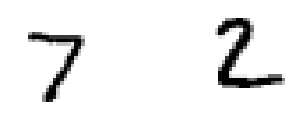

In [57]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring dictionary consisting of two digits and send it to deployed model to get predictions.

In [58]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1, image_2]}
    ]
}
scores = client.deployments.score(deployment_uid, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "values": [
        [
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          1.0,
          0.0,
          0.0
        ],
        [
          0.0,
          0.0,
          1.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0
        ]
      ]
    }
  ]
}


#### List deployments

In [ ]:
client.deployments.list(limit=5)

<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cpd4.5/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to train and score PyTorch models.  
 Check out our [Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/analyze-data/wml-setup.html) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020, 2021, 2022 IBM. This notebook and its source code are released under the terms of the MIT License.